# Car Evaluation Problem

Car Evaluation Dataset: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

Purpose: Provide an estimate for the acceptability of a car's price based on 6 fatures.

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

<h2>1. Import Dataset</h2>

In [2]:
#Car Evaluation Dataset: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation
#Purpose: Provide an estimate for the acceptability of a car's price based on 6 fatures:

headers = ["Buying Price", "Maintanence", "#Doors", "#Persons", "Trunk Size", "Safety", "Acceptability"]
#data = np.loadtxt('./datasets/carPrice/car_data.csv', delimiter = ',', dtype = str)
data = pd.read_csv('./datasets/CAR/car.data.csv', header = None, names = headers)
#print(data[:5])#Data preview
data.head()#Data preview

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
#Checking what data types we have in the dataset
print(data.dtypes)
#Result shows that they are all string objects

#Check for any Null values in the Dataset
data[data.isnull().any(axis=1)]
#Result shows that there are no null values

Buying Price     object
Maintanence      object
#Doors           object
#Persons         object
Trunk Size       object
Safety           object
Acceptability    object
dtype: object


,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability


In [4]:
#Ordinal encoding using SKlearn's label encoder function
lb_Make = LabelEncoder()
data["Buying Price"] = lb_Make.fit_transform(data["Buying Price"])
data["Maintanence"] = lb_Make.fit_transform(data["Maintanence"])
data["#Doors"] = lb_Make.fit_transform(data["#Doors"])
data["#Persons"] = lb_Make.fit_transform(data["#Persons"])
data["Trunk Size"] = lb_Make.fit_transform(data["Trunk Size"])
data["Safety"] = lb_Make.fit_transform(data["Safety"])
data["Acceptability"] = lb_Make.fit_transform(data["Acceptability"])
data.head()

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [5]:
#Convert Data to a numpy Array
data = data.values

#Relabel the last column as either acceptable or unacceptable to convert this problem into a classification problem
data[data[:,6] == 0,6] = 1
data[data[:,6] == 1,6] = 1
data[data[:,6] == 3,6] = 1
data[data[:,6] == 2,6] = 0

print(data[0:5,:])#Preview

[[3 3 0 0 2 1 0]
 [3 3 0 0 2 2 0]
 [3 3 0 0 2 0 0]
 [3 3 0 0 1 1 0]
 [3 3 0 0 1 2 0]]


In [6]:
#Data splitting
partitionVal = 0.8
breakNum = int(partitionVal*len(data))

X_train_val = data[:breakNum,:6]
Y_train_val = data[:breakNum,6]
X_test = data[breakNum:,:6]
Y_test = data[breakNum:,6]

print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(1382, 6) (346, 6) (1382,) (346,)


<h2>2. Declare classifier functions</h2>

In [7]:
global count 
count = 0
def draw_heatmap(acc, acc_desc, C_list, character):
    global count
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$'  + character + '$')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.savefig('./Results/carEvaluation/' + str(count) + '.jpg', bbox_inches = 'tight')
    plt.show()
    count+=1

In [8]:
def svm_func():
    #SVM binary classification
    classifier = svm.SVC(kernel = 'linear')
    C_list     = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1] # Different C to try.
    parameters = {'C': C_list}
    clf = GridSearchCV(classifier, parameters, return_train_score = 'true', cv=5)#Perform a grid Search to identify the best C
    clf.fit(X_train_val, Y_train_val)#fit the classifier with the training data

    #Extract the training and validation accuracies and plot them as heat maps tovisualize the best C parameter
    train_acc = clf.cv_results_['mean_train_score']
    draw_heatmap(train_acc.reshape(-1,1), 'train accuracy', C_list, 'C')

    val_acc = clf.cv_results_['mean_test_score']
    draw_heatmap(val_acc.reshape(-1,1), 'val accuracy', C_list, 'C')

    #Find the optimal C parameter and use that to redefine the classifier
    optimal_classifier = svm.SVC(kernel = 'linear', C = clf.best_params_['C'] )
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]
            
    #Find test accuracy
    optimal_classifier.fit(X_train_val, Y_train_val)
    test_acc = optimal_classifier.score(X_test, Y_test)
    return test_acc, best_train_acc, clf.best_params_['C']

In [9]:
def svm_func_boost():
    classifier = svm.SVC(kernel = 'linear')
    C_list     = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1] # Different C to try.
    parameters = {'C': C_list}
    clf = GridSearchCV(classifier, parameters, return_train_score = 'true', cv=5)#Perform a grid Search to identify the best C
    clf.fit(X_train_val, Y_train_val)#fit the classifier with the training data
    optimal_classifier = svm.SVC(kernel = 'linear', C = clf.best_params_['C'] )
    
    boostedSVM = AdaBoostClassifier(optimal_classifier, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    for i,j in enumerate(C_list):
        if j == clf.best_params_['C']:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, clf.best_params_['C']

In [10]:
def decision_Tree():
    #Decision Tree Classifier
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(5,1), 'DT train accuracy', D_list, 'D')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(5,1), 'DT val accuracy', D_list, 'D')
    #train/test with best parameter
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_star, criterion="entropy")
    classifier_test.fit(X_train_val, Y_train_val)
    Desicion_test_acc = classifier_test.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return Desicion_test_acc, best_train_acc, D_star

In [11]:
def decision_tree_boost():
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_star, criterion="entropy")
    
    boostedSVM = AdaBoostClassifier(classifier_test, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, D_star

In [12]:
def rand_Forest():
    #random forest classifier
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(5,1), 'RF train accuracy', D_list, 'K')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(5,1), 'RF val accuracy', D_list, 'K')

    #train/test with best parameter
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_star, criterion="entropy")
    classifier_test1.fit(X_train_val, Y_train_val)
    randForest_acc = classifier_test1.score(X_test,Y_test)
    
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return randForest_acc, best_train_acc, D_star

In [13]:
def random_forest_boost():
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    D_star = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_star, criterion="entropy")
    
    boostedSVM = AdaBoostClassifier(classifier_test1, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(D_list):
        if j == D_star:
            best_train_acc = train_acc[i]
    
    return test_acc, best_train_acc, D_star

In [14]:
#knn classifier
def knn_classifier():
    k_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':k_list}
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)

    #plot heatmaps
    draw_heatmap(classifier_grid.cv_results_['mean_train_score'].reshape(6,1), 'KNN train accuracy', k_list, 'K')
    draw_heatmap(classifier_grid.cv_results_['mean_test_score'].reshape(6,1), 'KNN val accuracy', k_list, 'K')

    #train/test with best parameter
    k_star = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=k_star)
    classifier_test2.fit(X_train_val,Y_train_val)
    knn_acc = classifier_test2.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(k_list):
        if j == k_star:
            best_train_acc = train_acc[i]
    
    return knn_acc, best_train_acc, k_star

In [15]:
def knn_boost():
    k_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':k_list}
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    classifier_grid.fit(X_train_val, Y_train_val)
    k_star = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=k_star)
    
    boostedSVM = AdaBoostClassifier(classifier_test2, algorithm = "SAMME")
    boostedSVM.fit(X_train_val, Y_train_val)
    test_acc = boostedSVM.score(X_test,Y_test)
    
    train_acc = classifier_grid.cv_results_['mean_train_score']
    for i,j in enumerate(k_list):
        if j == k_star:
            best_train_acc = train_acc[i]
    
    
    return test_acc, best_train_acc, k_star

<h2>3. Classification</h2> 

Partition:  0.8


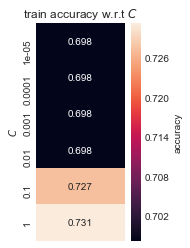

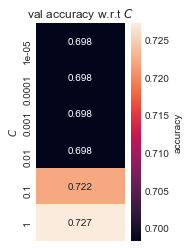

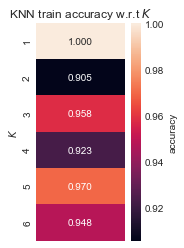

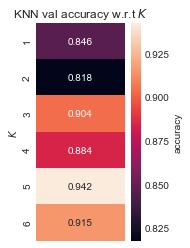

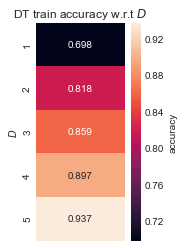

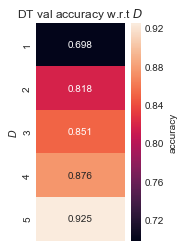

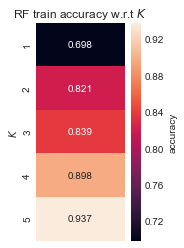

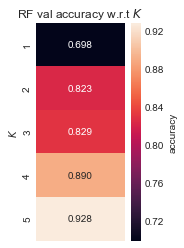

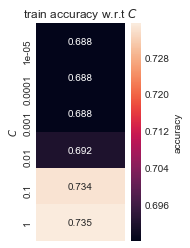

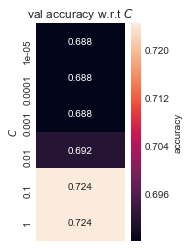

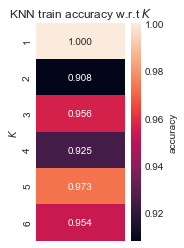

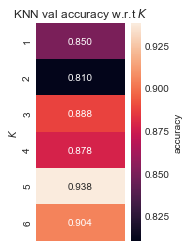

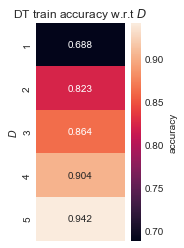

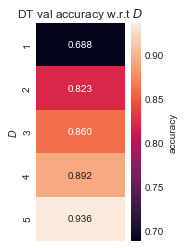

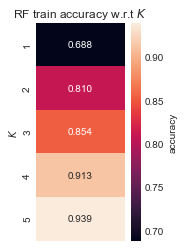

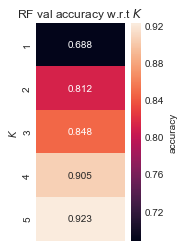

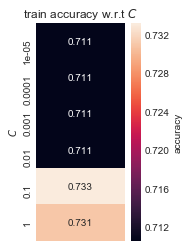

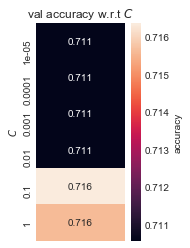

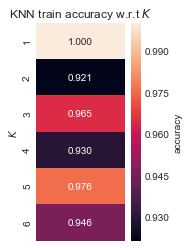

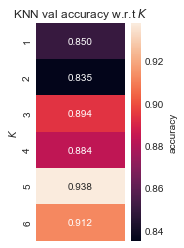

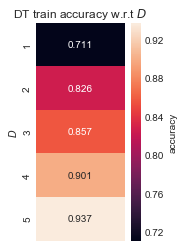

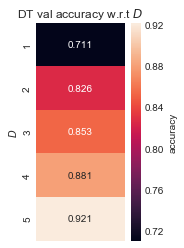

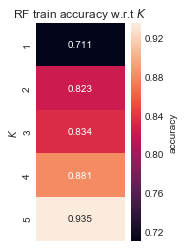

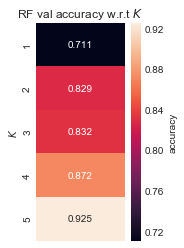

Test Accuracy Average for knn =  0.934489402697
Test Accuracy Average for Random Forest =  0.944123314066
Test Accuracy Average for Boosted Random Forest =  0.998073217726
Test Accuracy Average for Decision Tree =  0.938342967245
Test Accuracy Average for Boosted Decision Tree =  1.0
Test Accuracy Average for SVM =  0.71387283237
Test Accuracy Average for Boosted SVM =  0.705202312139
Partition:  0.5


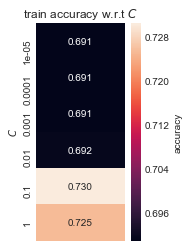

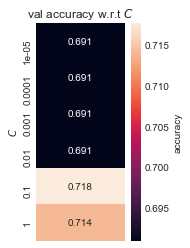

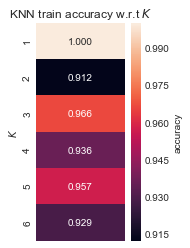

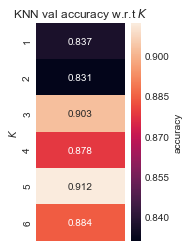

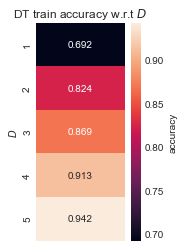

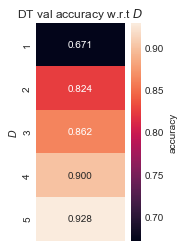

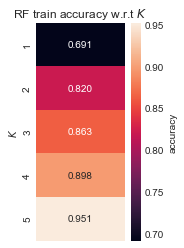

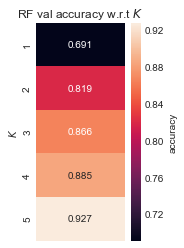

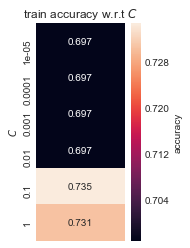

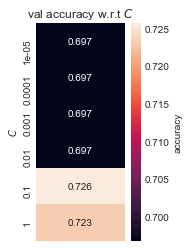

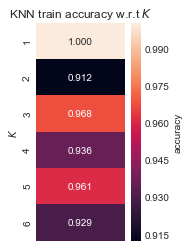

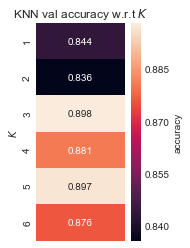

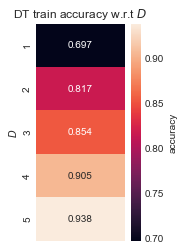

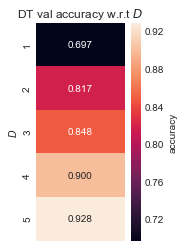

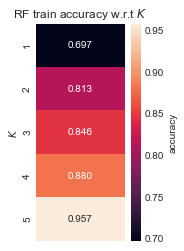

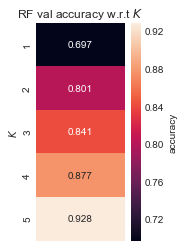

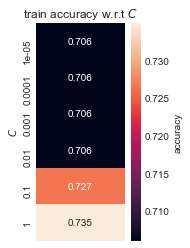

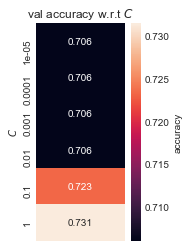

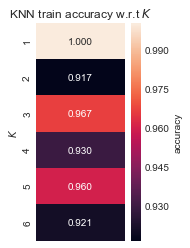

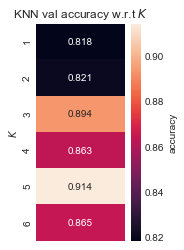

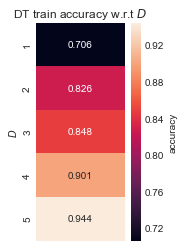

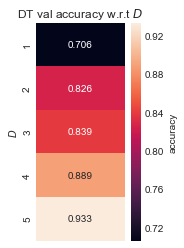

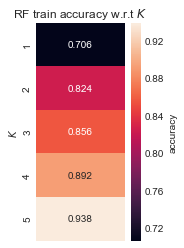

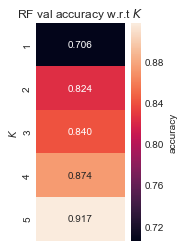

Test Accuracy Average for knn =  0.917438271605
Test Accuracy Average for Random Forest =  0.89737654321
Test Accuracy Average for Boosted Random Forest =  0.990354938272
Test Accuracy Average for Decision Tree =  0.929012345679
Test Accuracy Average for Boosted Decision Tree =  0.996527777778
Test Accuracy Average for SVM =  0.720679012346
Test Accuracy Average for Boosted SVM =  0.702546296296
Partition:  0.2


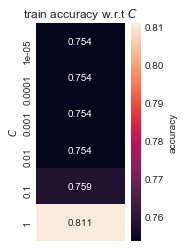

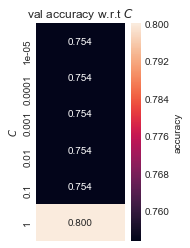

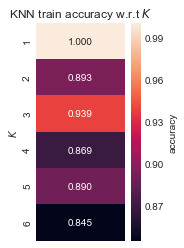

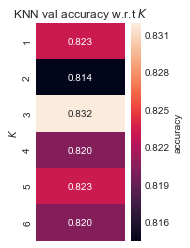

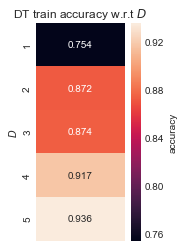

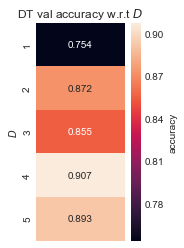

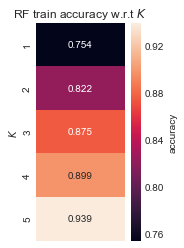

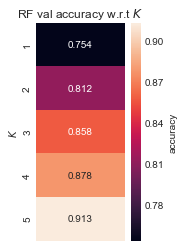

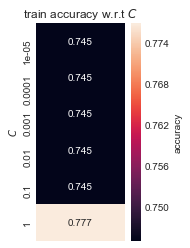

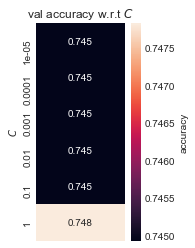

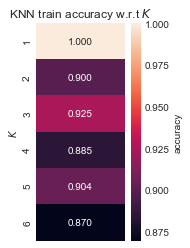

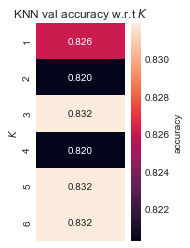

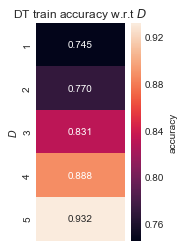

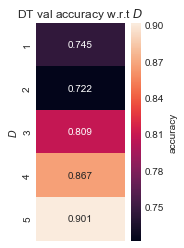

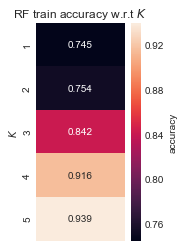

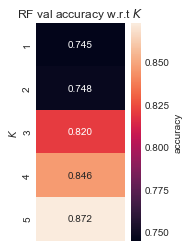

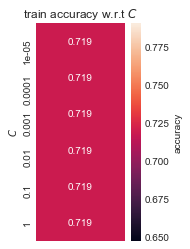

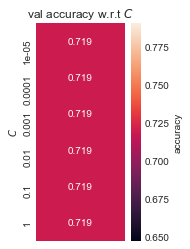

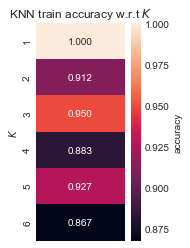

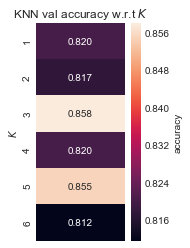

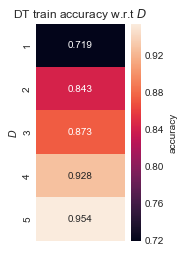

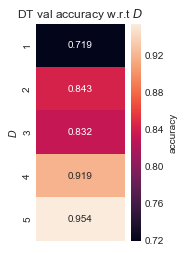

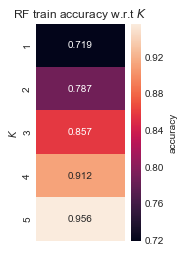

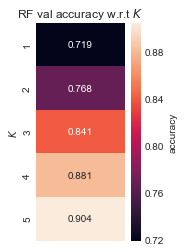

Test Accuracy Average for knn =  0.832007712702
Test Accuracy Average for Random Forest =  0.887201735358
Test Accuracy Average for Boosted Random Forest =  0.947457218607
Test Accuracy Average for Decision Tree =  0.90985779706
Test Accuracy Average for Boosted Decision Tree =  0.967944082912
Test Accuracy Average for SVM =  0.707640395276
Test Accuracy Average for Boosted SVM =  0.690527838033


In [274]:
partitionVal = [0.8,0.5,0.2]
result_table = np.zeros((3,7))
result_table1 = np.zeros((3,7))
result_table2 = np.zeros((3,7))
for i, partition in enumerate(partitionVal):
    print("Partition: ", partition)
    knn_test_acc = []
    rand_forest_test_acc = []
    decision_tree_test_acc = []
    svm_test_acc = []
    
    knn_boosted_test_acc = []
    rand_forest_boosted_test_acc = []
    decision_tree_boosted_test_acc = []
    svm_boosted_test_acc = []
    
    NUM_TRIALS = 3
    for trial in range(NUM_TRIALS):
        np.random.shuffle(data) #shuffle data
        breakNum = int(partition*len(data)) #Find the point where to partition the data
        
        X_train_val = data[:breakNum,:6]
        Y_train_val = data[:breakNum,6]
        X_test = data[breakNum:,:6]
        Y_test = data[breakNum:,6]
        
        #classifiers = ["SVM", "Decision Tree", "Random Forest",  "KNN"]
        test_acc,best_train0,C0 = svm_func()
        svm_test_acc.append(test_acc)#call the svm classifier
        test_acc,best_train1,C1 = knn_classifier()
        knn_test_acc.append(test_acc)#call the knn classifier
        test_acc,best_train2,C2 = decision_Tree()
        decision_tree_test_acc.append(test_acc)#call the Decision Tree classifier
        test_acc,best_train3,C3 = rand_Forest()
        rand_forest_test_acc.append(test_acc)#call the Random Forest classifier
        #knn_boosted_test_acc.append(knn_boost())
        test_acc,best_train4,C4 = svm_func_boost()
        svm_boosted_test_acc.append(test_acc)#call the svm boosted classifier
        test_acc,best_train5,C5 = decision_tree_boost()
        decision_tree_boosted_test_acc.append(test_acc)
        test_acc,best_train6,C6 = random_forest_boost()
        rand_forest_boosted_test_acc.append(test_acc)       
        
    result_table[i, 0] = sum(svm_test_acc)/NUM_TRIALS
    result_table[i, 1] = sum(knn_test_acc)/NUM_TRIALS
    result_table[i, 2] = sum(decision_tree_test_acc)/NUM_TRIALS
    result_table[i, 3] = sum(rand_forest_boosted_test_acc)/NUM_TRIALS
    result_table[i, 4] = sum(svm_boosted_test_acc)/NUM_TRIALS
    result_table[i, 5] = sum(decision_tree_boosted_test_acc)/NUM_TRIALS
    result_table[i, 6] = sum(rand_forest_boosted_test_acc)/NUM_TRIALS
    
    result_table1[i, 0] = best_train0
    result_table1[i, 1] = best_train1
    result_table1[i, 2] = best_train2
    result_table1[i, 3] = best_train3
    result_table1[i, 4] = best_train4
    result_table1[i, 5] = best_train5
    result_table1[i, 6] = best_train6
    
    result_table2[i, 0] = C0
    result_table2[i, 1] = C1
    result_table2[i, 2] = C2
    result_table2[i, 3] = C3
    result_table2[i, 4] = C4
    result_table2[i, 5] = C5
    result_table2[i, 6] = C6
        
    #Average all test accuracies for all 3 trials
    print("Test Accuracy Average for knn = ", sum(knn_test_acc)/NUM_TRIALS)
    #print("Test Accuracy Average for Boosted knn = ", sum(knn_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Random Forest = ", sum(rand_forest_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted Random Forest = ", sum(rand_forest_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Decision Tree = ", sum(decision_tree_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted Decision Tree = ", sum(decision_tree_boosted_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for SVM = ", sum(svm_test_acc)/NUM_TRIALS)
    print("Test Accuracy Average for Boosted SVM = ", sum(svm_boosted_test_acc)/NUM_TRIALS)

In [276]:
#y-axis: partition
#x-axis: classifier
#print(result_table)
print(result_table1)
print(result_table2)

[[ 0.73317339  0.97576101  0.93704745  0.93469369  0.72608696  0.93704745
   0.93324785]
 [ 0.73495353  0.96006709  0.9435747   0.93807877  0.73478261  0.9435747
   0.93546925]
 [ 0.71884288  0.95001782  0.95362269  0.95583869  0.68115942  0.95362269
   0.95146717]]
[[  1.00000000e-01   5.00000000e+00   5.00000000e+00   5.00000000e+00
    1.00000000e-01   5.00000000e+00   5.00000000e+00]
 [  1.00000000e+00   5.00000000e+00   5.00000000e+00   5.00000000e+00
    1.00000000e+00   5.00000000e+00   5.00000000e+00]
 [  1.00000000e-05   3.00000000e+00   5.00000000e+00   5.00000000e+00
    1.00000000e-05   5.00000000e+00   5.00000000e+00]]
